# Deep Learning-Based Credit Card Fraud Detection System

This notebook develops a credit card fraud detection system using deep learning. It involves loading and exploring the dataset, preprocessing (scaling, splitting, handling imbalance), building and training a neural network with TensorFlow/Keras, evaluating performance, and creating a Gradio interface for predictions.

In [1]:
# CELL 1: Install & Import Everything (Run once)
!pip install gradio -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             precision_recall_curve, auc, f1_score, accuracy_score,
                             ConfusionMatrixDisplay, precision_score, recall_score)
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import gradio as gr
import joblib

print("All libraries loaded!")

All libraries loaded!


In [2]:
# CELL 2: Load the Dataset
url = 'https://github.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/raw/master/creditcard.csv'
df = pd.read_csv(url)
print("Dataset loaded!")
df.head()

Dataset loaded!


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# CELL 3: Basic Exploration
print(f"Total Transactions: {len(df)}")
print(f"Fraudulent: {df['Class'].sum()} → {df['Class'].mean()*100:.3f}%")
print(f"Normal: {len(df)-df['Class'].sum()}")

print("\nMissing Values?")
print(df.isnull().sum().sum(), "→ None! Perfect")

print("\nClass Distribution:")
print(df['Class'].value_counts())

Total Transactions: 284807
Fraudulent: 492 → 0.173%
Normal: 284315

Missing Values?
0 → None! Perfect

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64


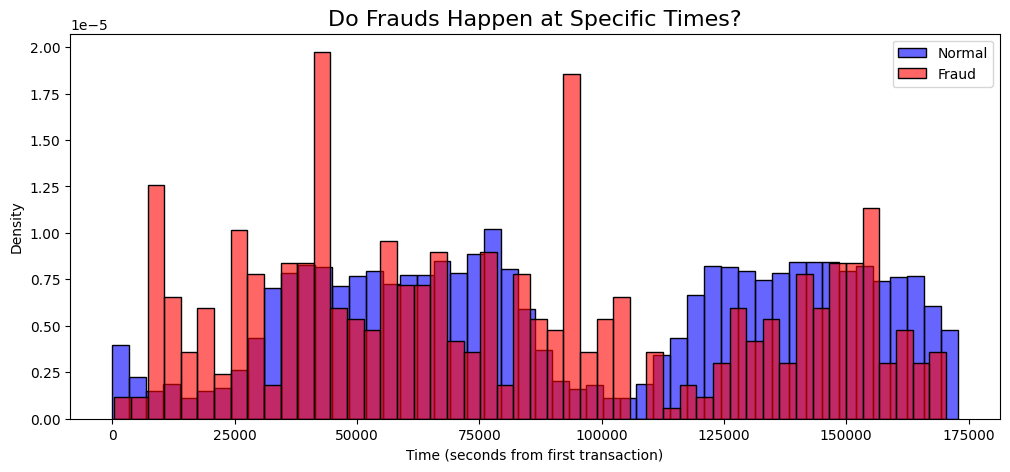

No clear time pattern → We will drop 'Time' feature


In [4]:
# CELL 4: Time Distribution Plot
plt.figure(figsize=(12,5))
fraud = df[df['Class']==1]
normal = df[df['Class']==0]

sns.histplot(normal['Time'], bins=50, alpha=0.6, color='blue', label='Normal', stat='density')
sns.histplot(fraud['Time'], bins=50, alpha=0.6, color='red', label='Fraud', stat='density')
plt.title('Do Frauds Happen at Specific Times?', fontsize=16)
plt.xlabel('Time (seconds from first transaction)')
plt.legend()
plt.show()

print("No clear time pattern → We will drop 'Time' feature")

In [5]:
# CELL 5: Prepare Features & Target
X = df.drop(['Time', 'Class'], axis=1)  # Remove Time & target
y = df['Class']

print(f"Features: {X.shape[1]} → V1-V28 + Amount")
print("Ready for modeling!")

Features: 29 → V1-V28 + Amount
Ready for modeling!


In [6]:
# CELL 6: Train-Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training: {len(X_train)} transactions")
print(f"Testing: {len(X_test)} transactions")
print(f"Frauds in test set: {y_test.sum()}")

Training: 227845 transactions
Testing: 56962 transactions
Frauds in test set: 98


In [7]:
# CELL 7: Scale Features (Critical!)
scaler = StandardScaler()
scaler.fit(X_train)  # Learn from training data only!

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled properly (mean=0, std=1)")

Features scaled properly (mean=0, std=1)


In [9]:
# CELL 8: Handle Class Imbalance with Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class Weights (to make fraud matter more):")
print(f"Normal (0): {class_weight_dict[0]:.2f}")
print(f"Fraud  (1): {class_weight_dict[1]:.0f} × more important!")

Class Weights (to make fraud matter more):
Normal (0): 0.50
Fraud  (1): 289 × more important!


In [10]:
# CELL 9: Build the Neural Network
model = Sequential([
    Input(shape=(29,)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['auc']
)

print("Model Architecture:")
model.summary()

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,033 (15.75 KB)

 Trainable params: 4,033 (15.75 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# CELL 10: Train the Model
print("Training started... (50 epochs)")

history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=2048,
    validation_split=0.2,
    class_weight=class_weight_dict,
    verbose=1
)

print("Training Complete!")

Training started... (50 epochs)
Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - auc: 0.7431 - loss: 0.7303 - val_auc: 0.9591 - val_loss: 0.3327
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9464 - loss: 0.2620 - val_auc: 0.9738 - val_loss: 0.2044
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9691 - loss: 0.2103 - val_auc: 0.9803 - val_loss: 0.1583
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9732 - loss: 0.1782 - val_auc: 0.9860 - val_loss: 0.1410
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9811 - loss: 0.1624 - val_auc: 0.9868 - val_loss: 0.1305
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9858 - loss: 0.1464 - val_auc: 0.9852 - val_loss: 0.1024
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9823 - loss: 0.1551 - val_auc: 0.9860 - val_loss: 0.0989
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9900 - loss: 0.1320 - val_auc: 0.9851 - val_loss: 0.0931
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0

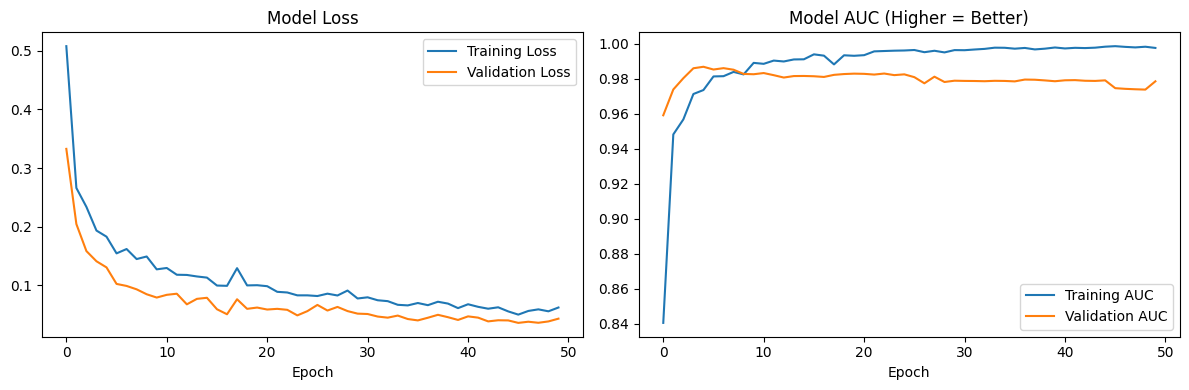

In [12]:
# CELL 11: Training History Plots
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC (Higher = Better)')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# CELL 12: Make Predictions
y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("Predictions done!")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Predictions done!


FINAL MODEL PERFORMANCE
Accuracy       : 0.9852
Precision      : 0.0962
Recall (Fraud) : 0.9082 ← Very Important!
F1 Score       : 0.1740
AUC Score      : 0.9786 ← Excellent!


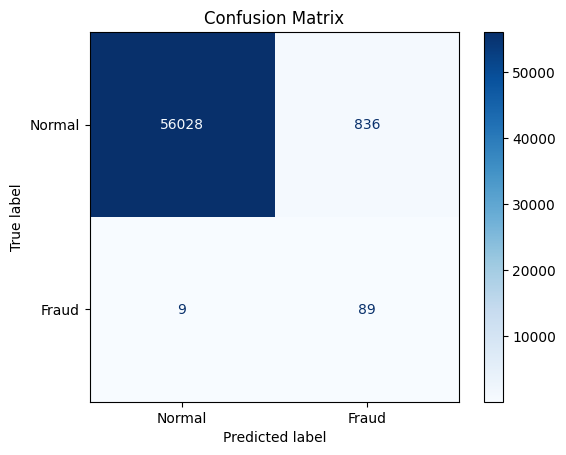

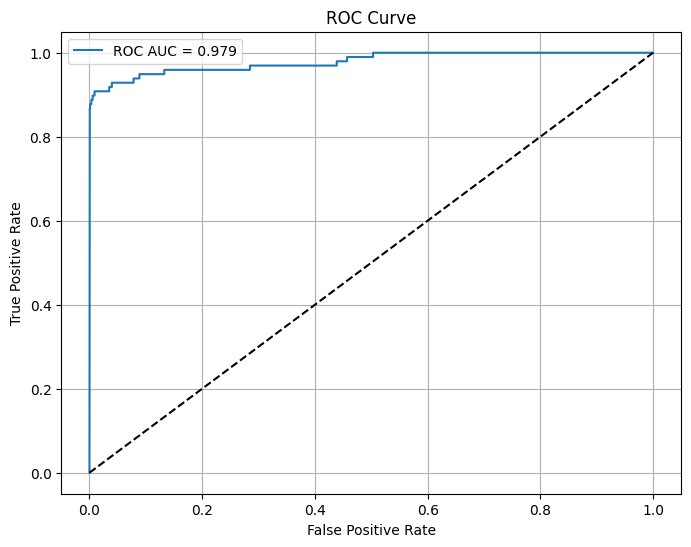

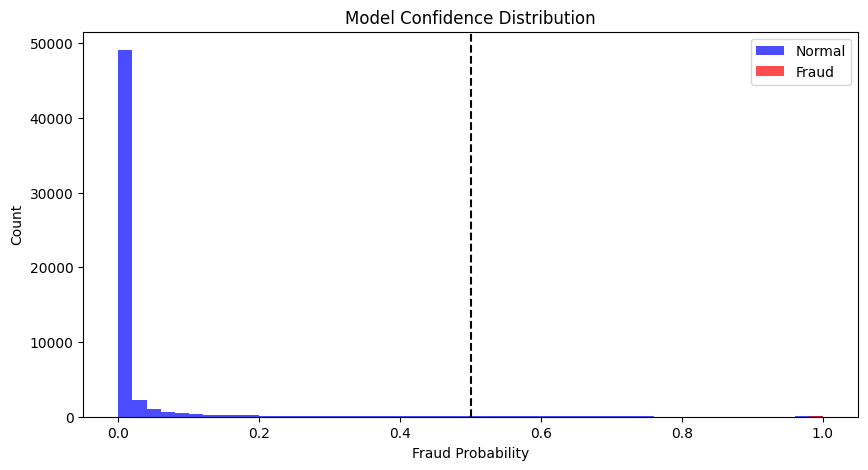

In [14]:
# CELL 13: ALL EVALUATION METRICS + GRAPHS
print("="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)

print(f"Accuracy       : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision      : {precision_score(y_test, y_pred):.4f}")
print(f"Recall (Fraud) : {recall_score(y_test, y_pred):.4f} ← Very Important!")
print(f"F1 Score       : {f1_score(y_test, y_pred):.4f}")
print(f"AUC Score      : {roc_auc_score(y_test, y_pred_prob):.4f} ← Excellent!")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_pred_prob):.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Fraud Probability Distribution
plt.figure(figsize=(10,5))
plt.hist(y_pred_prob[y_test==0], bins=50, alpha=0.7, label='Normal', color='blue')
plt.hist(y_pred_prob[y_test==1], bins=50, alpha=0.7, label='Fraud', color='red')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlabel('Fraud Probability')
plt.ylabel('Count')
plt.title('Model Confidence Distribution')
plt.legend()
plt.show()

In [15]:
# CELL 14: Save Model & Scaler (For Future Use)
model.save('credit_card_fraud_model.h5')
joblib.dump(scaler, 'fraud_scaler.pkl')

print("Model & Scaler saved! Ready for real-world use")

Model & Scaler saved! Ready for real-world use


In [16]:
# CELL 15: Gradio Prediction Functions (With Alert!)
feature_columns = X.columns.tolist()

def predict_single(v_str, amount):
    try:
        v_list = [float(x.strip()) for x in v_str.split(',')]
        if len(v_list) != 28:
            return "Error: Exactly 28 V-values needed", 0.0

        data = v_list + [amount]
        df_input = pd.DataFrame([data], columns=feature_columns)
        scaled = scaler.transform(df_input)
        prob = model.predict(scaled)[0][0]
        pred = "FRAUD DETECTED! BLOCK!" if prob > 0.5 else "Transaction Approved"
        return pred, round(float(prob), 4)
    except:
        return "Invalid input", 0.0

def predict_batch(file):
    df_batch = pd.read_csv(file)
    orig = df_batch.copy()
    if 'Time' in df_batch.columns: df_batch.drop('Time', axis=1, inplace=True)
    if 'Class' in df_batch.columns: df_batch.drop('Class', axis=1, inplace=True)
    df_batch = df_batch[feature_columns]
    scaled = scaler.transform(df_batch)
    probs = model.predict(scaled).flatten()
    orig['Fraud_Probability'] = probs.round(4)
    orig['Prediction'] = ['FRAUD' if p>0.5 else 'SAFE' for p in probs]
    return orig

In [ ]:
# CELL 16: Launch Beautiful Web App
print("Launching your fraud detection app...")

interface = gr.TabbedInterface(
    [gr.Interface(fn=predict_single,
                   inputs=[gr.Textbox(label="V1-V28 (comma-separated)", lines=2),
                           gr.Number(label="Amount")],
                   outputs=[gr.Label(label="Result"), gr.Number(label="Fraud Probability")],
                   title="Single Transaction Check"),

     gr.Interface(fn=predict_batch,
                   inputs=gr.File(label="Upload CSV"),
                   outputs=gr.Dataframe(),
                   title="Batch Prediction")]
    ,
    tab_names=["Single Check", "Batch Upload"]
)

interface.launch(share=True, debug=True)

Launching your fraud detection app...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d711243870487fffb7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Created dataset file at: .gradio/flagged/dataset1.csv
